# NuClick:Interactive Annotation for Pathology

### Inference Notebook

In [37]:
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [38]:
import json
import copy
import math
import os
import numpy as np
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]

from skimage.measure import regionprops
from monai.engines import SupervisedTrainer, SupervisedEvaluator
from monai.handlers import (
    CheckpointSaver,
    MeanDice,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
    ValidationHandler,
    from_engine
)
from monai.inferers import SimpleInferer
from monai.losses import DiceLoss
from monai.networks.nets import BasicUNet
from monai.data import (
    Dataset,
    DataLoader,
)
from monai.transforms import (
    Activationsd,
    AddChanneld,
    AsChannelFirstd,
    AsDiscreted,
    Compose,
    EnsureTyped,
    LoadImaged,
    LoadImage,
    RandRotate90d,
    ScaleIntensityRangeD,
    ToNumpyd,
    TorchVisiond,
    ToTensord,
)

from monai.apps.nuclick.transforms import (
    FlattenLabeld,
    ExtractPatchd,
    SplitLabeld,
    AddPointGuidanceSignald,
    FilterImaged
)

## Utility Functions

`split_nuclei_dataset` for all the per label splits, there can be multiple nuclei in the given patch, this particular function provides the centroid of the image and also selects a single nuclei for a single training pair and the other nuclei get masked out

In [15]:
def split_nuclei_dataset(d, centroid_key="centroid", mask_value_key="mask_value", min_area=5):
    dataset_json = []

    mask = LoadImage(image_only=True, dtype=np.uint8)(d["label"])
    _, labels, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

    stats = regionprops(labels)
    for stat in stats:
        if stat.area < min_area:
            print(f"++++ Ignored label with smaller area => ( {stat.area} < {min_area})")
            continue

        x, y = stat.centroid
        x = int(math.floor(x))
        y = int(math.floor(y))

        item = copy.deepcopy(d)
        item[centroid_key] = (x, y)
        item[mask_value_key] = stat.label

        dataset_json.append(item)
    return dataset_json

## Define Model Path for Inference

Since we are using the pre-processed data for the inference, the section "Create Json, form training and validation split" of the training notebook needs to be executed in order for the pre-processed data to be used here

Also configure `model_weights_path` to the best saved validation metric model file name

In [47]:
#Add the code paths here
logging_dir = os.path.normpath('/home/vishwesh/nuclick_experiments/try_6/')

dataset_path = os.path.join(logging_dir, 'data')
json_path = os.path.join(logging_dir, 'data_list.json')
model_weights_path = os.path.join(logging_dir, 'network_key_metric=0.8494.pt')

In [48]:
    patch_size = 128
    min_area = 5
    val_transforms = Compose(
        [
            LoadImaged(keys=("image", "label"), dtype=np.uint8),
            FilterImaged(keys="image", min_size=5),
            FlattenLabeld(keys="label"),
            AsChannelFirstd(keys="image"),
            AddChanneld(keys="label"),
            ExtractPatchd(keys=("image", "label"), patch_size=patch_size),
            SplitLabeld(keys="label", others="others", mask_value="mask_value", min_area=min_area),
            ToTensord(keys="image"),
            TorchVisiond(
                keys="image", name="ColorJitter", brightness=64.0 / 255.0, contrast=0.75, saturation=0.25, hue=0.04
            ),
            ToNumpyd(keys="image"),
            RandRotate90d(keys=("image", "label", "others"), prob=0.5, spatial_axes=(0, 1)),
            ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
            AddPointGuidanceSignald(image="image", label="label", others="others", drop_rate=1.0),
            EnsureTyped(keys=("image", "label"))
        ]
    )

In [49]:
    device = torch.device("cuda")

    network = BasicUNet(
        spatial_dims=2,
        in_channels=5,
        out_channels=1,
        features=(32, 64, 128, 256, 512, 32),
    )
    
    # The saved weights is a state_dict already
    model_weights = torch.load(model_weights_path)
    #print(model_weights)
    network.load_state_dict(model_weights)
    network.to(device)

BasicUNet features: (32, 64, 128, 256, 512, 32).


BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2

In [50]:
# Load the json file and get a couple of samples for inferencing
with open(json_path, 'rb') as j_file:
    json_data = json.load(j_file)
j_file.close()

test_data = json_data[0:1]

test_data_new = []
for d in tqdm(test_data):
    test_data_new.extend(split_nuclei_dataset(d, min_area=min_area))

test_ds = Dataset(data=test_data_new, 
                  transform=val_transforms,
                  )

test_loader = DataLoader(test_ds, 
                         batch_size=1, 
                         shuffle=False, 
                         num_workers=1, 
                         pin_memory=True
                        )

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.82it/s]


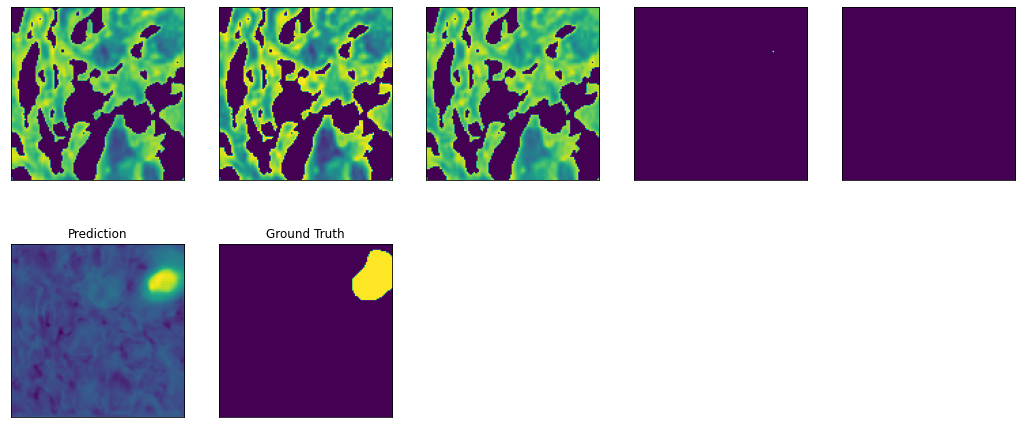

In [57]:
network.eval()
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        
        batch['image'] = batch['image'].to(device)
        pred = network(batch['image'])
        
        image = batch['image'].to('cpu').numpy()
        for plt_img in range(1, 6):
            plt.subplot(2, 5, plt_img)
            plt.imshow(np.squeeze(image[0, plt_img-1, :, :]))
            plt.xticks([])
            plt.yticks([])
        
        plt.subplot(2, 5, 6)
        pred = pred.to('cpu').numpy()
        plt.imshow(pred[0, 0, :, :])
        plt.xticks([])
        plt.yticks([])
        plt.title('Prediction')

        plt.subplot(2, 5, 7)
        label = batch['label'].to('cpu').numpy()
        plt.imshow(label[0, 0, :, :])
        plt.xticks([])
        plt.yticks([])
        plt.title('Ground Truth')
            
        break
        
        

## End of Notebook